In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet18 import ResNet18
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import scipy
from sklearn.metrics import fbeta_score
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,  load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

In [25]:
import pandas as pd
import numpy as np
import os
import sys
from shutil import copyfile
import os.path
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from PIL import Image
from sklearn.model_selection import train_test_split
from numpy import load
import matplotlib.pyplot as plt
imagegen = ImageDataGenerator()

In [26]:
# load train data from drive
disease_types=['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']


train_generator=imagegen.flow_from_directory('/content/drive/MyDrive/BitkiHastaligiTeshisi - OzgeOzaras/KODLAR/PlantVillage-Patato/Dataset',
                                             shuffle=False, batch_size=64, target_size=(224, 224),seed=42 )
x=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(x.shape)
print(y.shape)

Found 2152 images belonging to 3 classes.
(2152, 224, 224, 3)
(2152, 3)


In [27]:
#Converting  our color images to a vector
x=x.reshape(2152,224*224*3)

In [28]:
x.shape

(2152, 150528)

In [29]:
#Apply SMOTE method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(x, y)

In [30]:
X_smote.shape

(3000, 150528)

In [31]:
y_smote.shape

(3000, 3)

In [32]:
X_smote=X_smote.reshape(3000,224,224,3)

In [33]:
print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {X_smote.shape}''')



Shape of X before SMOTE: (2152, 150528)
Shape of X after SMOTE: (3000, 224, 224, 3)


In [34]:

IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


In [35]:
"""
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))"""
# Normalize the data
X_smote = X_smote / 255.
print('Train Shape: {}'.format(X_smote.shape))


Train Shape: (3000, 224, 224, 3)


In [36]:
#Y_train = train['DiseaseID'].values
#Y_train = to_categorical(Y_train)

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [38]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [39]:
from keras.applications import MobileNetV2
def build_MobilNetV2():
    mobilnetv2 = MobileNetV2(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = mobilnetv2(x)
    x = Flatten(name="flatten")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
    # model
    model = Model(input,output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [40]:
model_mobilnet=build_MobilNetV2()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout_2 (Dropout)         (None, 62720)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               16056576  
                                                           

In [41]:
# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [42]:
hist_mobilnetv1=model_mobilnet.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.8200
Epoch 1: val_accuracy improved from -inf to 0.35167, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 33s 357ms/step - loss: 0.5256 - accuracy: 0.8200 - val_loss: 4.5043 - val_accuracy: 0.3517
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9771
Epoch 2: val_accuracy improved from 0.35167 to 0.36833, saving model to best_model.h5
38/38 [==============================] - 12s 313ms/step - loss: 0.0636 - accuracy: 0.9771 - val_loss: 3.5393 - val_accuracy: 0.3683
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9921
Epoch 3: val_accuracy improved from 0.36833 to 0.39667, saving model to best_model.h5
38/38 [==============================] - 12s 312ms/step - loss: 0.0272 - accuracy: 0.9921 - val_loss: 3.1730 - val_accuracy: 0.3967
Epoch 4/100
38/38 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9962
Epoch 4: val_accuracy improved from 0.39667 to 0.42333, saving model to best_model.h5
38/38 [==============================] - 12s 310ms/step - los

In [43]:
# load the saved model
saved_model = load_model('best_model.h5')

In [44]:
y_pred = saved_model.predict(X_val)

19/19 [==============================] - 2s 45ms/step


In [45]:
y_pred=np.argmax(y_pred, axis=1)

In [46]:
Y_val=np.argmax(Y_val, axis=1)

In [47]:
print("ShuffleNet MODEL SONUÇLARI")
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

ShuffleNet MODEL SONUÇLARI
Doğruluk:  0.99
F1_Skor:  0.9902094257505248
Hassasiyet:  0.9901504936377304
Duyarlılık:  0.9903714446861654


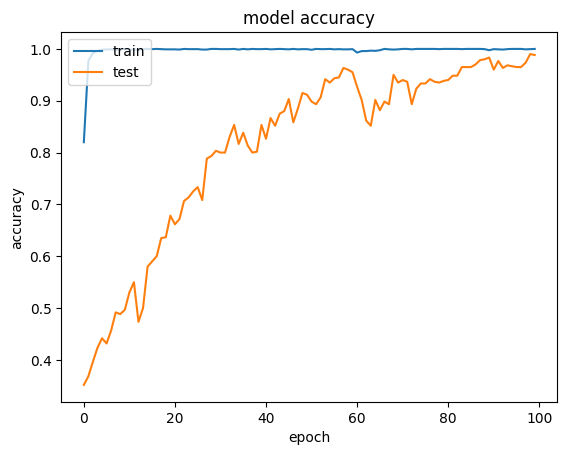

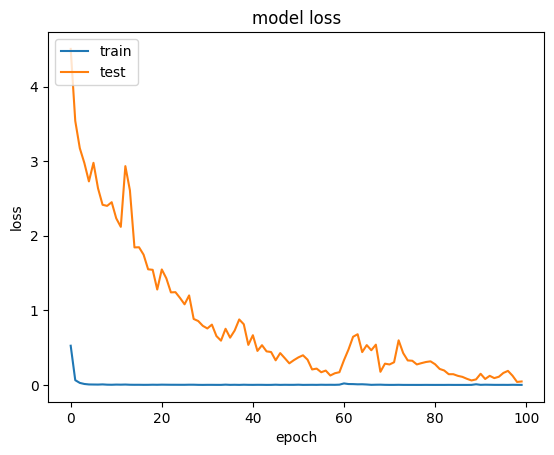

In [49]:

plt.plot(hist_mobilnetv1.history['accuracy'])
plt.plot(hist_mobilnetv1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist_mobilnetv1.history['loss'])
plt.plot(hist_mobilnetv1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion Matrix
[[213   4   0]
 [  1 196   0]
 [  0   1 185]]


<Axes: >

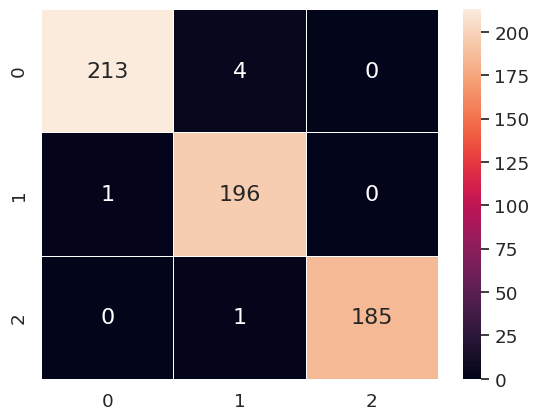

In [50]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cm_dense = confusion_matrix(Y_val, y_pred)
print(cm_dense)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm_dense, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size